In [4]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Read Dataset

In [5]:
# Read data from CSV file
df = pd.read_csv("winequality-red.csv", sep=';')

Dataset characteristics

Number of Records: 1599
Average Ratio of Std Dev to Range: 0.13311087779756628
Number of Records with Quality 5 or 6: 1319
Count of each quality value: 
Quality value: 3, Count: 10
Quality value: 4, Count: 53
Quality value: 5, Count: 681
Quality value: 6, Count: 638
Quality value: 7, Count: 199
Quality value: 8, Count: 18


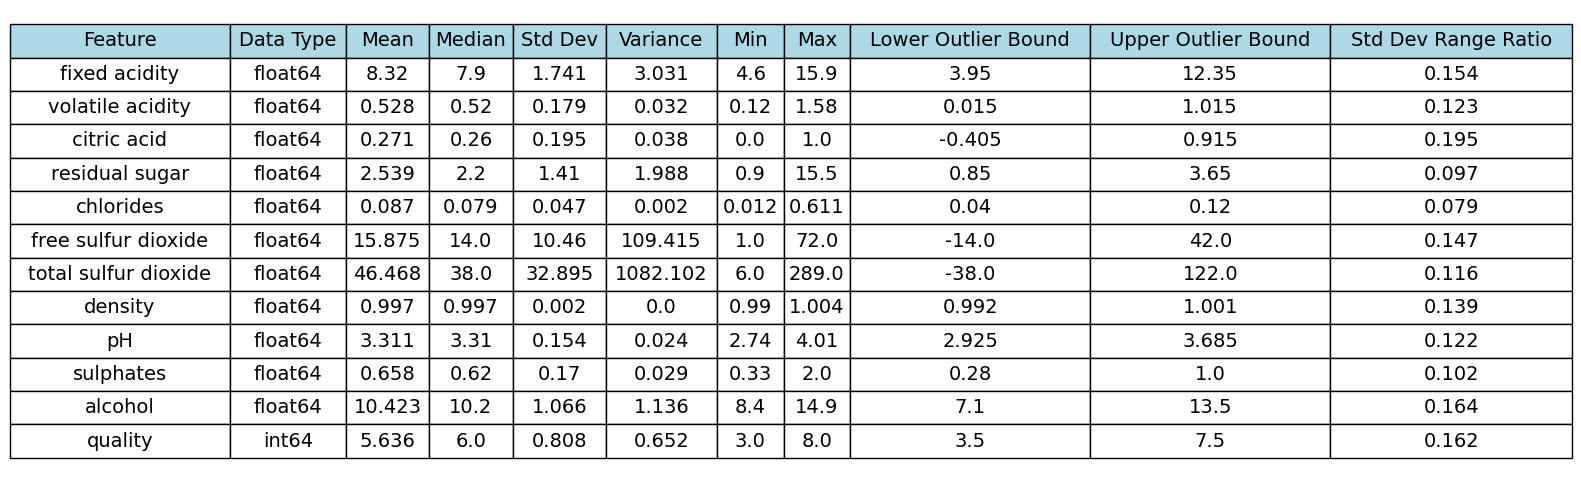

In [26]:
num_records = df.shape[0]
print("Number of Records:", num_records)

#find mean
feature_means = df.mean()

#create dataframe for feature statistics
feature_stats = pd.DataFrame(columns=['Feature', 'Data Type', 'Mean', 'Median', 'Std Dev', 'Variance', 'Min', 'Max', 'Lower Outlier Bound', 'Upper Outlier Bound', 'Std Dev Range Ratio'])

#find key statititics for each feature
for feature_name in df.columns:
    data_type = df[feature_name].dtype
    
    mean_value = feature_means[feature_name]
    
    median_value = df[feature_name].median()
    
    std_dev_value = df[feature_name].std()
    
    variance_value = df[feature_name].var()
    
    min_value = df[feature_name].min()
    
    max_value = df[feature_name].max()
    
    #generate ratio between standard deviation and range
    std_dev_range_ratio = std_dev_value / (max_value - min_value) if (max_value - min_value) != 0 else np.nan

    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1

    #generate upper and lower bound for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    #append to dataframe
    feature_stats.loc[len(feature_stats)] = [feature_name, data_type, mean_value, median_value, std_dev_value, variance_value, min_value, max_value, lower_bound, upper_bound, std_dev_range_ratio]

#find average standard deviation deviation to range ratio
average_ratio = feature_stats['Std Dev Range Ratio'].mean()
print("Average Ratio of Std Dev to Range:", average_ratio)

#find records with values 5 or 6
num_records_with_5_or_6 = df[df['quality'].isin([5, 6])].shape[0]

print("Number of Records with Quality 5 or 6:", num_records_with_5_or_6)

#print count of record with each quality value
print("Count of each quality value: ")
value_counts = df['quality'].value_counts().sort_index()
for quality_value, count in value_counts.items():
    print(f"Quality value: {quality_value}, Count: {count}")


#create table of dataset characteristics
feature_stats = feature_stats.round(3)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = feature_stats.values
headers = feature_stats.columns
table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')

table.auto_set_column_width(col=list(range(len(headers))))
table.scale(1, 2)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#add8e6')

plt.savefig("figs/data_qualities.png")
plt.show()

plot quality distribution

In [ ]:
#plot distribution of quality values
plt.figure(figsize=(8, 6))
sns.histplot(df['quality'], bins=range(1, 11), color='skyblue')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/qual_distribution.png")
plt.show()

generate dataset with features scaled

In [ ]:
#scale dataset with minmax scaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

scaled_df["quality"] = df["quality"]
scaled_df.to_csv('feature_scaled_dataset.csv', index=False)

Find dataset Outliers

In [ ]:
exclude_columns = ['quality']

outliers_dict = {}

for column in df.columns:
    if column not in exclude_columns:
        #find outliers for each feature
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        #add outliers for record to dictionary
        for index, row in outliers.iterrows():
            if index not in outliers_dict:
                outliers_dict[index] = []
            outliers_dict[index].append(column)

multi_outliers = 0


mean = 0

#display records with 3 or more outliers
for record_index, associated_columns in outliers_dict.items():
    if len(associated_columns) > 2:
        multi_outliers += 1
        mean += df.loc[record_index]["quality"]
        #print(f"\nPotential Outlier in Record {record_index}:")
        #print(f"Associated Columns: {', '.join(associated_columns)}")
        #print(df.loc[record_index])

mean = mean / multi_outliers

#print mean number of outliers and records with 3 or more outliers
print(mean)
print(multi_outliers)

Analyse Top 10 Records, Bottom 10 records, and median 10 records

In [ ]:
#sort dataset by qualitiy values
df_sorted = df.sort_values(by='quality', ascending=False)

#function to identify outliers in feature
def identify_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

#add columns that indicate whether values are outliers
for feature in df_sorted.columns:
    #for outliers over the upper bound
    df_sorted[f"{feature}_upper_outlier"] = identify_outliers(df_sorted[feature])

    #for outliers under the lower bound
    df_sorted[f"{feature}_lower_outlier"] = identify_outliers(df_sorted[feature])

#add feature for each record indicating the number of outliers
df_sorted['num_outliers'] = df_sorted.filter(like='_outlier').sum(axis=1)

#print average, top 10 records, bottom 10 records, and median 10 records by quality value
print(f'Average number of outliers: {df_sorted["num_outliers"].mean()}')

print("Top 10 Records:")
print(df_sorted.head(10))

print("\nBottom 10 Records:")
print(df_sorted.tail(10))

print("\nMedian 10 Records:")
median_index = len(df_sorted) // 2
median_records = df_sorted.iloc[median_index - 5 : median_index + 5]
print(median_records)

Create 

create box plots for data to identify outliers/ distribution

In [ ]:
plots = scaled_df.drop(columns=["quality"])

sns.set(style="whitegrid")

# Set the size of the plot
plt.figure(figsize=(16, 8))

# Plot box plots for each feature
sns.boxplot(data=plots, orient="h", palette="Set2")

# Set the title
plt.title("Box Plot for Each Feature", fontsize=16)

plt.savefig("figs/feature_boxplot_distributions.png")
# Show the plot
plt.show()

generate correlation matrix and associated figure

In [ ]:
# make correlation matrix
correlation_matrix = df.corr()

#show correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.savefig("figs/correlation_matrix.png")
plt.show()

Generate VIF values

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display VIF values
print(vif_data)

combine correlated variables to produce new dataset

In [ ]:
feature_comb_data = df
feature_comb_data["combined acidity"] = feature_comb_data["fixed acidity"] * feature_comb_data["pH"] * feature_comb_data["citric acid"]
feature_comb_data = feature_comb_data.drop(columns=["fixed acidity", "citric acid", "pH"])
feature_comb_data.to_csv('combined_acid_dataset.csv', index=False)
print(feature_comb_data)

Perform Dataset Preprocessing for Proposed Model and Save to CSV File

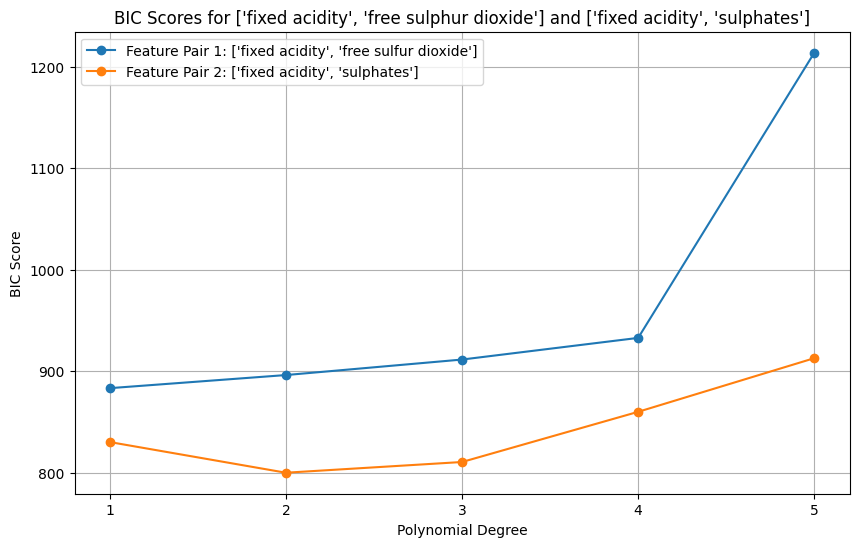

InvalidParameterError: The 'degree' parameter of PolynomialFeatures must be an int in the range [0, inf) or an array-like. Got 822.7892804681173 instead.

In [10]:
#find number of records with each quality value
value_counts = df['quality'].value_counts()
#choose 3rd largest quality size as sampling size for larger quality bins
num_records_per_bin = sorted(value_counts)[2]

#intialise empty dataframe for stratified sampple
stratified_sample = pd.DataFrame()


#stratify the sample based on "quality" variable
for quality_value in range(3, 9):
    if len(df[df['quality'] == quality_value]) < num_records_per_bin:
        updated_num = len(df[df['quality'] == quality_value])
    else:
        updated_num = num_records_per_bin
        
    #sample a fixed number of records for each "quality" value
    stratified_sample = pd.concat([stratified_sample, df[df['quality'] == quality_value].sample(updated_num)])

#remove target from data
numeric_data = stratified_sample.drop(columns=["quality"])
y = stratified_sample["quality"]

#scale data to fall between 0-1
scaler = MinMaxScaler()
scaled_numeric_data = scaler.fit_transform(numeric_data)
scaled_numeric_df = pd.DataFrame(scaled_numeric_data, columns=numeric_data.columns)

#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_numeric_df, y, test_size=0.2, random_state=42)

best_degrees = {}
plot_points = []

# iterate over all pairs of features
for i in range(numeric_data.shape[1]):
    for j in range(i + 1, numeric_data.shape[1]):
        feature_pair = [numeric_data.columns[i], numeric_data.columns[j]]
        
        # iterate over different degrees
        best_mse = float('inf')
        best_degree = None
        bics = {}
        for degree in range(1, 6):
            # create polynomial features for training and testing splits
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            poly_features_train = poly.fit_transform(X_train[feature_pair])
            poly_features_test = poly.transform(X_test[feature_pair])

            # train model with new features
            model = LinearRegression()
            model.fit(poly_features_train, y_train)
            
            # evaluate model
            y_pred = model.predict(poly_features_test)
            
            # calculate BIC score
            ss_eps = np.sum((y_test - y_pred) ** 2)
            bic = len(X_train) * np.log(ss_eps) + degree * np.log(len(X_train))
        
            # store in BICs dictionary
            bics[degree] = bic

        # find and store best degree
        best_bic = min(bics, key=bics.get)
        best_degree = bics[best_bic]
        best_degrees[tuple(feature_pair)] = best_degree
        
        # add BIC values to plot_points
        if (feature_pair == ['fixed acidity', 'free sulfur dioxide']) or (feature_pair == ['fixed acidity', 'sulphates']):
            plot_points.append([list(bics.values()), feature_pair])

# plot bic values
plt.figure(figsize=(10, 6))
for i, (points, feature_pair) in enumerate(plot_points):
    plt.plot(range(1, 6), points, marker='o', linestyle='-', label=f'Feature Pair {i+1}: {feature_pair}')

plt.title("BIC Scores for ['fixed acidity', 'free sulphur dioxide'] and ['fixed acidity', 'sulphates']")
plt.xticks(range(1, 6))
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC Score')
plt.legend()
plt.grid(True)
plt.savefig("figs/BIC_combined.png")
plt.show()


#create a new DataFrame for polynomial features
rescaled_features_df = pd.DataFrame()

#add polynomial relationships to dataframe
for feature_pair, best_degree in best_degrees.items():
    poly = PolynomialFeatures(degree=best_degree, include_bias=False)
    poly_features = poly.fit_transform(numeric_data[list(feature_pair)])

    # scaler = MinMaxScaler()
    # scaled_numeric_data = np.column_stack([scaler.fit_transform(poly_features[:, i:i+1]) for i in range(poly_features.shape[1])])

    feature_columns = [f"{feature}_deg{best_degree}" for feature in range(scaled_numeric_data.shape[1])]
    scaled_numeric_df = pd.DataFrame(scaled_numeric_data, columns=feature_columns)

    rescaled_features_df = pd.concat([rescaled_features_df, scaled_numeric_df], axis=1)

#calculate the covariance matrix
cov_matrix = np.cov(rescaled_features_df, rowvar=False)

#calculate the eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#calculate the percentage contribution of each eigenvalue
percentage_contribution = np.round((eigenvalues / np.sum(eigenvalues)) * 100, decimals=2)

#print eigenvalues 
# print("Eigen Values for All Covariance Eigenvectors:\n")
# for i, eigenvalue in enumerate(eigenvalues):
#     print(f"Eigenvalue for EigenVector {i+1}: {eigenvalue} ({percentage_contribution[i]}%)\n")
    
#sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

#choose number of components to keep
cumulative_variance = np.cumsum(percentage_contribution)

# Find the number of components that explain 95% of the variance
num_components = np.argmax(cumulative_variance >= 95) + 1

#create projection matrix
projection_matrix = eigenvectors[:, :num_components]

#transform original dataset to a PCA dimensionality reduced dataset
pca_reduced_data = rescaled_features_df.dot(np.real(eigenvectors))

#reset indices to reconnect records
pca_reduced_data.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#return target variable to records
pca_reduced_data['quality'] = y


#save as csv
pca_reduced_data.to_csv('pca_reduced_dataset.csv', index=False)
    


Create Pie chart to illustrate eigen significance

In [ ]:
#plot the pie chart with distinct colors for each section
plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(eigenvalues)))  # Use a range of distinct colors
patches, texts, autotexts = plt.pie(eigenvalues, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)

#create a color-coded legend with both feature name and percentage
legend_labels = [f"Eigenvector {i+1} ({percentage:.1f}%)"
                 for i, percentage in enumerate(percentage_contribution)]

for text in texts + autotexts:
    text.set_text("")

plt.legend(patches, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Percentage of Eigenvalue Significance', loc='left')
plt.tight_layout()
plt.savefig("figs/covariance_eigenvectors_pie.png")
plt.show()